### Load Context

In [1]:
import os
import sys
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

os.chdir("/Users/kipnisal/DS/BiblicalScripts/bib-scripts/")
sys.path.append("/Users/kipnisal/DS/BiblicalScripts/bib-scripts/src")

from kedro.framework.session import KedroSession

with KedroSession.create("biblical_scripts") as session:
    ctx = session.load_context()

params = ctx.params


/usr/local/lib/python3.8/site-packages/patsy/constraint.py:13: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.9 it will stop working
  from collections import Mapping
/usr/local/lib/python3.8/site-packages/statsmodels/iolib/foreign.py:651: DeprecationWarning: `np.long` is a deprecated alias for `np.compat.long`. To silence this warning, use `np.compat.long` by itself. In the likely event your code does not need to work on Python 2 you can use the builtin `int` for which `np.compat.long` is itself an alias. Doing this will not modify any behaviour and is safe. When replacing `np.long`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/pyth

2021-11-11 12:10:39,471 - kedro.framework.session.store - INFO - `save()` not implemented for `BaseSessionStore`. Skipping the step.


# chunk_len --  Text Length vs Accuracy

In [3]:
sim_res = ctx.catalog.load('sim_len_res')

/usr/local/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


2021-11-11 12:03:42,703 - kedro.io.data_catalog - INFO - Loading data from `sim_len_res` (CSVDataSet)...


In [60]:
def _eval_succ(df) :
    """
    Indicate whetehr minimal discripancy is obtained by the true author.
    """
    idx_min = df.groupby(['doc_id', 'author'])['value'].idxmin()
    res_min = df.loc[idx_min, :].rename(columns={'corpus' : 'most_sim'})
    res_min.loc[:, 'succ'] = res_min.author == res_min.most_sim
    return res_min


In [67]:
value = "HC"
df1 = sim_res[sim_res['variable'].str.contains(f":{value}")]
df1.loc[:,'corpus'] = df1['variable'].str.extract(r'([^:]+):')[0]
df1['author'] = df1['true_author']
df1['doc_id'] = df1['experiment'] + ":" + df1['true_author'] \
            + ":" + df1['itr'].astype(str) + ":" + df1['chunk_size'].astype(str)
df1 = df1.reset_index()

df_res = _eval_succ(df1)

# average over chunk_len
df_res['succ'] = df_res['succ'] + .0
grp = df_res.groupby('chunk_size')
res = grp.agg({'succ' : ['mean', 'std',
                           lambda x : pd.Series.quantile(x, q=.2),
                           lambda x : pd.Series.quantile(x, q=.8)
                          ]}, as_index=False).reset_index()

res[f'succ_mean'] = res[('succ', 'mean')]
res[f'succ_std'] = res[('succ', 'std')]
res[f'succ_CI_lower'] = res[('succ', '<lambda_0>')]
res[f'succ_CI_upper'] = res[('succ', '<lambda_1>')]
res = res.drop('succ', axis=1, level=0)
res

/usr/local/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


,chunk_size,succ_mean,succ_std,succ_CI_lower,succ_CI_upper
,,,,,
0,5,0.660000,0.474500,0.0,1.0
1,10,0.750000,0.433736,0.0,1.0
2,15,0.800000,0.400668,0.8,1.0
3,20,0.826667,0.379168,1.0,1.0
4,25,0.830000,0.376260,1.0,1.0
5,30,0.803333,0.398142,1.0,1.0
6,40,0.836667,0.370287,1.0,1.0
7,50,0.790000,0.407989,0.0,1.0
8,60,0.866667,0.340503,1.0,1.0


# Sim full  

In [2]:
sim_full_res = ctx.catalog.load("sim_full_res")
print("len res = ",len(sim_full_res))

/usr/local/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


2021-11-11 12:10:40,865 - kedro.io.data_catalog - INFO - Loading data from `sim_full_res` (CSVDataSet)...
len res =  6590


#### Report

In [3]:
import plotnine
import logging
plotnine.options.figure_size = (10, 6)
from plotnine import *
logging.basicConfig(level=logging.INFO)

/usr/local/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


In [4]:
#os.chdir("/Users/kipnisal/DS/BiblicalScripts/bib-scripts/src")
from biblical_scripts.pipelines.reporting.nodes import report_table_full_known, report_table_full_unknown
report_table_full_known(sim_full_res, params['report'], params['known_authors'] )


report_table_full_unknown(sim_full_res, params['report'], params['unk_authors'])

2021-11-11 12:10:42,766 - numexpr.utils - INFO - NumExpr defaulting to 8 threads.


NameError: name 'res_known' is not defined

In [6]:
params

{'preprocessing': {'extract_prefix': True,
  'extract_suffix': False,
  'morph_code_only': True,
  'flat_suff_person': True,
  'ng_min': 1,
  'ng_max': 1,
  'pad': False,
  'to_remove': ['FFF'],
  'to_replace': ['FFF', 'Ac', 'Ng', 'Np']},
 'vocab': {'no_tokens': 3000, 'by_author': True},
 'model': {'feat_reduction_method': 'none',
  'gamma': 0.35,
  'stbl': True,
  'min_cnt': 1,
  'measures': ['HC']},
 'known_authors': ['Dtr', 'DtrH', 'P'],
 'unk_authors': ['Ark1',
  'Ark2',
  'Late_Abraham',
  'Gibea',
  'Early_Jacob',
  'Chr2',
  'Chr1',
  'Esth',
  'Prov',
  'Lev26'],
 'all_authors': ['Dtr',
  'DtrH',
  'P',
  'Ark1',
  'Ark2',
  'Late_Abraham',
  'Gibea',
  'Early_Jacob',
  'Chr2',
  'Chr1',
  'Esth',
  'Prov',
  'Lev26'],
 'report': {'value': 'HC',
  'fig_path': 'data/08_reporting/Figs',
  'min_length_to_report': 200,
  'sig_level': 0.05,
  'known_authors': ['Dtr', 'DtrH', 'P']},
 'bootstrapping': {'nBS': 100, 'value': 'HC', 'reduce_feature': 'None'},
 'sim_full': {'n': 200,
  'mi

In [287]:
value = ctx.params['report']['value']
df_all = sim_full_res
sig_level = .05

# df_gen = df[df.kind == 'generic']
# df_ext = df[df.kind == 'extended']

df = _arrange_metadata(df_all, value)

lo_docs = df.doc_tested.unique().tolist()
res = pd.DataFrame()
for doc in lo_docs :
    df1 = df[df.doc_tested == doc]
    df1.loc[:, 'rnk'] = df1.groupby('corpus')['value'].rank() 
    num_of_docs = df1.groupby('corpus')['value'].transform('count')
    df1.loc[:, 'rnk_pval'] = 1 - df1.loc[:, 'rnk'] / num_of_docs
    df2 = df1[df1.kind == 'generic']
    res = res.append(df2, ignore_index=True)

res_known=res[res.author.isin(params['known_authors'])]

/usr/local/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


In [290]:
res_known=res[~res.author.isin(params['known_authors'])]

res_tbl = res_known.pivot('corpus', 'doc_id', 'rnk_pval')
lo_corpora = res_known.corpus.unique().tolist()
cmin = res_tbl.idxmax().rename('max_pval_corpus')
res_tbl = res_tbl.append(cmin)

res_tbl.loc['author', :] = [r[1] for r in res_tbl.columns.str.split(' by ')]
res_tbl.loc['succ', :] = res_tbl.loc['max_pval_corpus',:] == res_tbl.loc['author',:]

# add length info
#res_tbl = res_tbl.T.merge(res_known[['doc_id', 'len']].drop_duplicates(), on='doc_id').T

#compute false alarm rate
res_tbl.loc['false_alarm', :] = False
for auth in params['known_authors'] :
    idcs = res_tbl.loc['author',:] == auth
    res_tbl.loc['false_alarm', idcs] = res_tbl.loc[auth, idcs] < sig_level

res_tbl['mean'] = res_tbl.loc[lo_corpora + ['succ', 'false_alarm'],:].mean(1)


res_tbl

/usr/local/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


doc_id,chapter0 by Ark1,chapter0 by Ark2,chapter0 by Chr1,chapter0 by Chr2,chapter0 by Early_Jacob,chapter0 by Esth,chapter0 by Gibea,chapter0 by Late_Abraham,chapter0 by Lev26,chapter0 by Prov,mean
corpus,,,,,,,,,,,
Dtr,0.03125,0.59375,0.03125,0.03125,0.03125,0.03125,0.03125,0.03125,0.03125,0.03125,0.087500
DtrH,0.09375,0.90625,0.03125,0.09375,0.09375,0.09375,0.03125,0.03125,0.03125,0.03125,0.143750
P,0.013158,0.565789,0.013158,0.013158,0.013158,0.013158,0.013158,0.013158,0.013158,0.013158,0.068421
max_pval_corpus,DtrH,DtrH,Dtr,DtrH,DtrH,DtrH,Dtr,Dtr,Dtr,Dtr,NaN
author,Ark1,Ark2,Chr1,Chr2,Early_Jacob,Esth,Gibea,Late_Abraham,Lev26,Prov,NaN
succ,False,False,False,False,False,False,False,False,False,False,0.000000
false_alarm,False,False,False,False,False,False,False,False,False,False,0.000000


NameError: name 'value' is not defined

In [212]:
res_known.pivot_table(index='doc_id', values = ['succ', 'false_alarm'])

,false_alarm,succ
doc_id,,
1Kgs.8 by DtrH,0.333333,1.0
2Kgs.17 by DtrH,0.000000,1.0
2Kgs.22 by DtrH,0.000000,1.0
2Kgs.23 by DtrH,0.000000,1.0
2Kgs.24 by DtrH,0.000000,0.0
...,...,...
Lev.2 by P,0.000000,1.0
Lev.3 by P,0.000000,1.0
Lev.4 by P,0.333333,1.0


/usr/local/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


,author,doc_id,len,variable,value,doc_tested,itr,smp_len,kind,len_doc_tested,corpus,rnk,rnk_pval,succ
18,Dtr,Deut.9 by Dtr,810.0,Dtr:HC,2.297087,Deut.9 by Dtr,0,810,generic,810,Dtr,13.5,0.100000,False
19,Dtr,Deut.9 by Dtr,810.0,DtrH:HC,2.397293,Deut.9 by Dtr,0,810,generic,810,DtrH,10.5,0.343750,False
20,Dtr,Deut.9 by Dtr,810.0,P:HC,4.598059,Deut.9 by Dtr,0,810,generic,810,P,32.5,0.144737,False
33,Dtr,Deut.15 by Dtr,590.0,Dtr:HC,2.369684,Deut.15 by Dtr,0,590,generic,590,Dtr,14.5,0.033333,False
34,Dtr,Deut.15 by Dtr,590.0,DtrH:HC,2.897764,Deut.15 by Dtr,0,590,generic,590,DtrH,12.5,0.218750,False
35,Dtr,Deut.15 by Dtr,590.0,P:HC,3.693282,Deut.15 by Dtr,0,590,generic,590,P,26.5,0.302632,False
48,Dtr,Deut.27 by Dtr,483.0,Dtr:HC,2.241993,Deut.27 by Dtr,0,483,generic,483,Dtr,12.5,0.166667,False
49,Dtr,Deut.27 by Dtr,483.0,DtrH:HC,1.722033,Deut.27 by Dtr,0,483,generic,483,DtrH,7.5,0.531250,False
50,Dtr,Deut.27 by Dtr,483.0,P:HC,4.090845,Deut.27 by Dtr,0,483,generic,483,P,30.5,0.197368,False
66,DtrH,2Kgs.24 by DtrH,466.0,Dtr:HC,2.313778,2Kgs.24 by DtrH,0,466,generic,466,Dtr,13.5,0.156250,False


In [160]:
report_params = params['report']
report_params['value'] = 'rnk_pval'
report_table(res, report_params)

/usr/local/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
/usr/local/lib/python3.8/site-packages/pandas/core/frame.py:9005: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


doc_id,mean
corpus,
min_corpus,NaN
author,NaN
succ,NaN


In [125]:
df1

,author,doc_id,len,variable,value,doc_tested,itr,smp_len,kind,len_doc_tested,corpus,rnk
6520,TEST,chapter0 by Prov,7063.0,Dtr:HC,10.055158,chapter0 by Prov,0,7063,generic,7063,Dtr,15.5
6521,TEST,chapter0 by Prov,7063.0,DtrH:HC,10.861384,chapter0 by Prov,0,7063,generic,7063,DtrH,15.5
6522,TEST,chapter0 by Prov,7063.0,P:HC,15.322299,chapter0 by Prov,0,7063,generic,7063,P,37.5
6523,TEST,Deut.6 by Dtr,540.0,Dtr-ext:HC,1.294324,chapter0 by Prov,1,540,extended,7063,Dtr,3.0
6524,TEST,Deut.8 by Dtr,474.0,Dtr-ext:HC,1.969377,chapter0 by Prov,2,474,extended,7063,Dtr,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...
6585,TEST,Lev.3 by P,388.0,P-ext:HC,3.773293,chapter0 by Prov,63,388,extended,7063,P,26.0
6586,TEST,Lev.4 by P,840.0,P-ext:HC,5.247955,chapter0 by Prov,64,840,extended,7063,P,34.0
6587,TEST,Lev.8 by P,902.0,P-ext:HC,3.043977,chapter0 by Prov,65,902,extended,7063,P,15.0
6588,TEST,Lev.9 by P,527.0,P-ext:HC,3.222739,chapter0 by Prov,66,527,extended,7063,P,16.0


In [95]:
params_report = params['report']


res0 = sim_full_res[sim_full_res.kind == 'generic']
report_table(res0, params_report)

/usr/local/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


doc_id,1Kgs.8 by DtrH,2Kgs.17 by DtrH,2Kgs.22 by DtrH,2Kgs.23 by DtrH,2Kgs.24 by DtrH,2Kgs.25 by DtrH,2Sam.7 by DtrH,Deut.10 by Dtr,Deut.11 by Dtr,Deut.12 by Dtr,...,chapter0 by Ark2,chapter0 by Chr1,chapter0 by Chr2,chapter0 by Early_Jacob,chapter0 by Esth,chapter0 by Gibea,chapter0 by Late_Abraham,chapter0 by Lev26,chapter0 by Prov,mean
corpus,,,,,,,,,,,,,,,,,,,,,
Dtr,3.672181,1.368709,3.256598,3.834573,2.313778,4.124821,2.898636,0.878064,-1.248289,1.94932,...,1.676092,7.920055,5.572031,3.551017,4.811268,5.093668,5.798267,4.237783,10.055158,3.565256
DtrH,3.893706,1.077634,1.59736,2.244747,1.897523,1.840701,2.472104,1.69473,2.244983,3.713117,...,0.898188,6.464119,3.847236,3.526588,3.733362,4.57857,5.309781,4.768969,10.861384,3.629240
P,6.608177,3.912826,3.624454,4.359904,3.181756,3.657657,5.396316,3.62924,4.44184,4.866209,...,3.000382,8.023083,8.651544,6.108624,7.705925,8.133355,8.715157,5.481934,15.322299,4.462360
min_corpus,Dtr,DtrH,DtrH,DtrH,DtrH,DtrH,DtrH,Dtr,Dtr,Dtr,...,DtrH,DtrH,DtrH,DtrH,DtrH,DtrH,DtrH,Dtr,Dtr,NaN
author,DtrH,DtrH,DtrH,DtrH,DtrH,DtrH,DtrH,Dtr,Dtr,Dtr,...,Ark2,Chr1,Chr2,Early_Jacob,Esth,Gibea,Late_Abraham,Lev26,Prov,NaN
succ,False,True,True,True,True,True,True,True,True,True,...,False,False,False,False,False,False,False,False,False,0.611940


In [72]:
def _arrange_metadata(df, value) :
    """
    adds 'corpus' and 'author' column to evaluation results
    """
    
    df = df[df.variable.str.contains(value)]
    df.loc[:,'corpus'] = sim_full_res.variable.str.extract(rf"(^[A-Za-z0-9 ]+)(-ext)?:([A-Za-z]+)")[0]
    df.loc[:,'author'] = df.doc_tested.str.extract(r"by (.+)")[0]
    return df


In [75]:
def _comp_probs(df : pd.DataFrame, by) -> pd.DataFrame :
    """
    mean, std and CI's over many iterations.
    """
    
    df.loc[:,'rank'] = np.floor(df.groupby(by)['value'].transform('rank'))

    df0 = df[df.kind == 'org']
    df1 = df[df.kind != 'org']

    #df1['corpus'] = df1['corpus'].str.extract(r'([A-Za-z0-9 ]+)-ext')[0]
    grp = df1.groupby(by)
    res = grp.agg({value : ['mean', 'std', 'count', 
                               lambda x : pd.Series.quantile(x, q=.05),
                               lambda x : pd.Series.quantile(x, q=.95)
                              ]}, as_index=False).reset_index()\
        .rename(columns = {'<lambda_0>' : 'CI05', '<lambda_1>' : 'CI95'})

    dfm = df0.merge(res[['doc_tested', 'corpus', 'value']],
                      on=['doc_tested', 'corpus'], how='right')

    mu = dfm[('value', 'mean')]
    std = dfm[('value' ,'std')]
    n = dfm[('value', 'count')]

    dfm.loc[:,'prob'] = 1 - (np.floor(dfm['rank'])-1) / n
    dfm.loc[:,'t-score'] = np.abs(dfm['value'] - mu) / (std * np.sqrt(n/(n-1)))
    dfm.loc[:,'t-test'] = scipy.stats.t.sf(dfm['t-score'], df=n-1)
    return dfm

def comp_probs(sim_full_res, params_report) :
    df = _arrange_metadata(sim_full_res, value=params_report['value'])
    dfm = _comp_probs(df, by = ['author', 'doc_tested', 'corpus'])
    return dfm
    
def report_probs(dfm) :
    return dfm.pivot('corpus', 'doc_tested', ['value', 'prob', 't-test', 'rank', 't-score'])

In [78]:
dfm = comp_probs(sim_full_res, params_report = params['report'])
dfm.to_csv('temp.csv')

KeyError: "Column 'HC' does not exist!"

In [77]:
plt.scatter(dfm['t-score'], dfm['prob'])
plt.scatter(dfm['t-score'], dfm['t-test'])
plt.show()

NameError: name 'dfm' is not defined

/usr/local/lib/python3.8/site-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
/usr/local/lib/python3.8/site-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
/usr/local/lib/python3.8/site-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
/usr/local/lib/python3.8/site-packages/plotnine/guides/guide_legend.py:302: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr

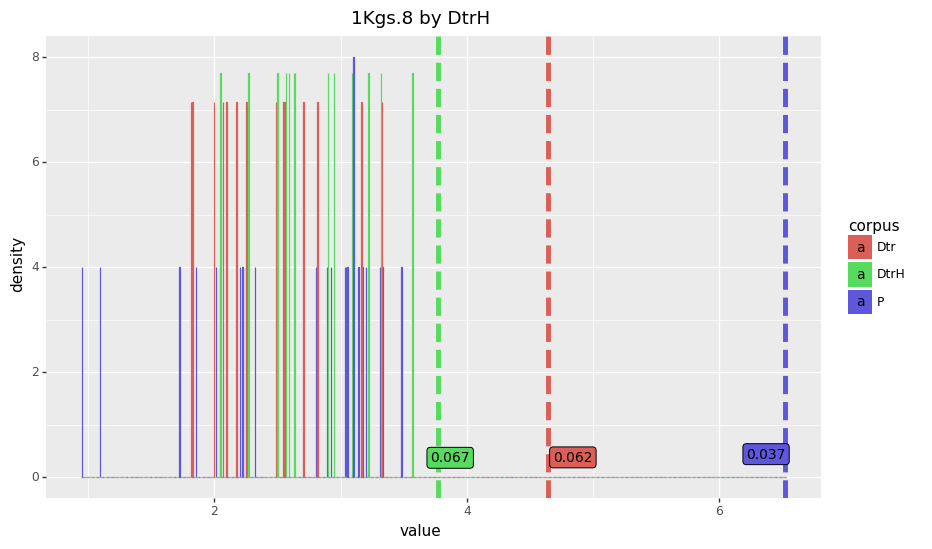

<ggplot: (343879762)>


In [1537]:
p = (ggplot(aes(x='value', fill = 'corpus', y='..density..',
            color='corpus', label='corpus'), data = res1_null)
         + geom_histogram(alpha=0.3,position='dodge', binwidth=.01) 
         #+ geom_density(alpha = 0.5)
         + geom_vline(aes(xintercept='value', color='corpus'),
                      data=res1_doc, size=2, linetype='dashed')
         + geom_label(data=res1_doc,
                          mapping=aes(x='value', y=0.5, label='prob', fill='corpus'),
                          position=position_jitter(),
                          size=10, colour = "black")
         + ggtitle('{}'.format(doc_nm)) )

#p.save('./Figs/simulated_null_{}_NG{}_temp.png'.format(auth,NG_RANGE))
print(p)
